In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sowfadict as sowfa
import tools
import pandas as pd
from matplotlib.colors import Normalize
import gzip
import matplotlib.colors as colors
from scipy.interpolate import interp1d

In [27]:
cases     = ['M2_SR_TurbBC','M2_SR_NoTurbBC','M2_SR_PertBC']
simstr    = ['PGx2.2En4_zi550','PGx4.4En4_zi550','PGx2.2En4_zi1100']#,'PGx4.4En4_zi550']
datadir   = '/home/phawbeck/SOWFA/Terrain/data/'
savedir   = '/home/phawbeck/SOWFA/Terrain/img/'
fdir      = '/projects/mmc/NWTCRegion/'
terrstr   = ['SR','D2']
figlabels = ['a','b','c','d','e','f']
terrstr_f = ['Complex Terrain','Smoothed Terrain']

nx = 896; ny = 208; nz = 75

nsims  = len(simstr)
ncases = len(cases)

In [28]:
initVars = False

for sim in range(0,nsims):
    for ss in range(0,len(terrstr)):
        if  not initVars:
            f    = open('{}{}_{}_normz_tke'.format(datadir,simstr[sim],terrstr[ss]),'r')
            head = f.readline().split()
            nxf, nzf  = int(head[1]), int(head[3])
            tke_norm  = np.zeros((nsims,len(terrstr),ncases+2,nxf,nzf))
            xz_norm   = np.zeros((nxf,nzf))
            zx_norm   = np.zeros((nxf,nzf))
            for ii in range(0,nxf):
                for kk in range(0,nzf):
                    line = f.readline().split()
                    xz_norm[ii,kk]   = float(line[0])
                    zx_norm[ii,kk]   = float(line[1])
            f.close()
            initVars  = True
        f = open('{}{}_{}_normz_tke'.format(datadir,simstr[sim],terrstr[ss]),'r')
        f.readline()
        for ii in range(0,nxf):
            for kk in range(0,nzf):
                line = f.readline().split()
                for cc in range(0,ncases+2):
                    tke_norm[sim,ss,cc,ii,kk]  = float(line[2+cc])
        f.close()

In [6]:
fdir     = '/projects/mmc/NWTCRegion/'

srtmzf = gzip.open('{}/{}/NWTC.run.M2_{}_TurbBC/constant/ccz.gz'.format(fdir,simstr[0],terrstr[0]),'r')
srtmzz = srtmzf.readlines()[22:-15]
srtmzf.close()
diffzf = gzip.open('{}/{}/NWTC.run.M2_{}_TurbBC/constant/ccz.gz'.format(fdir,simstr[0],terrstr[1]),'r')
diffzz = diffzf.readlines()[22:-15]
diffzf.close()

srtmz = np.zeros((nx,ny))
diffz = np.zeros((nx,ny))

ct = 0
for jj in range(0,ny):
    for ii in range(0,nx):
        srtmz[ii,jj] = np.float(srtmzz[ct])
        diffz[ii,jj] = np.float(diffzz[ct])
        ct += 1

/home/phawbeck/SOWFA/Terrain/img/PGx2.2En4_zi550_TKECompare.pdf


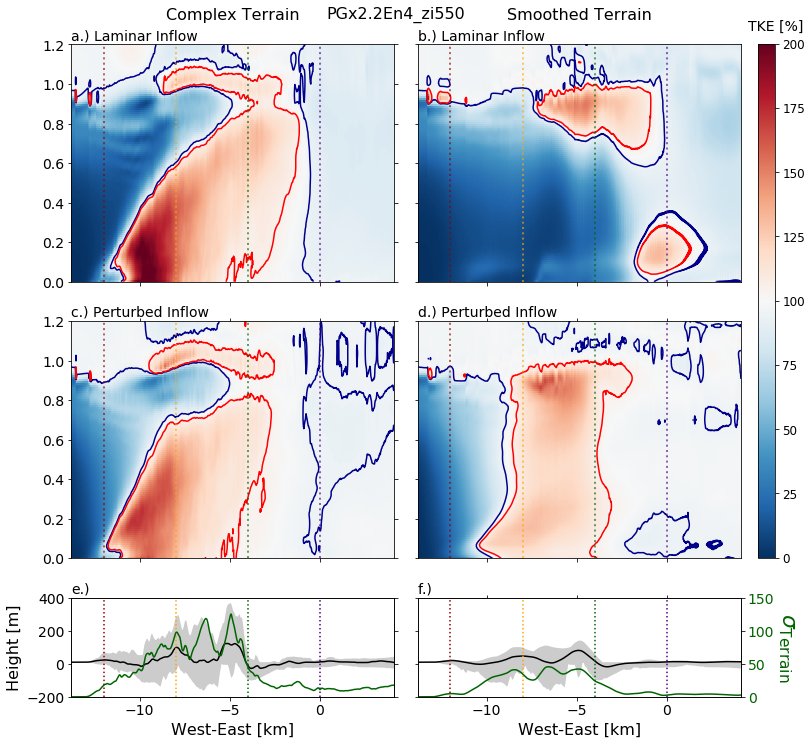

In [29]:
saveFig = False
simnum  = 0
textx   = -13.8 

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.4,wspace=0.075)
nrows = 5; ncols = 2
plt.suptitle(simstr[simnum],x=0.5,y=0.905,size=16,ha='center',va='bottom')
pp = 0
for cc in range(0,ncases-1):
    for tr in range(0,len(terrstr)):
        if cc == 0: pltstr = 'Laminar Inflow'
        if cc == 1: pltstr = 'Perturbed Inflow'
        pltstr_f = '{}.) {}'.format(figlabels[pp],pltstr)
        TKEpct = tke_norm[simnum,tr,3+cc]*100.0
        plt.subplot2grid((5,2),(cc*2,tr),rowspan=2)
        cont = plt.pcolormesh(xz_norm/1000.0,zx_norm,TKEpct,norm=Normalize(0.0,200.0),cmap=plt.cm.RdBu_r,rasterized=True)
        plt.contour(xz_norm/1000.0,zx_norm,TKEpct,levels=np.arange(95,96,1),colors='darkblue')
        plt.contour(xz_norm/1000.0,zx_norm,TKEpct,levels=np.arange(105,106,15),colors='r')

        plt.axvline(-12,color='darkred',  ls=':',alpha=0.6,lw=2.0) # Probe Line 1
        plt.axvline(-8, color='orange',   ls=':',alpha=0.6,lw=2.0) # Probe Line 3
        plt.axvline(-4, color='darkgreen',ls=':',alpha=0.6,lw=2.0) # Probe Line 5
        plt.axvline(0,  color='indigo',   ls=':',alpha=0.6,lw=2.0) # Probe Line 7
        plt.tick_params(labelbottom=False,labelsize=14)
        plt.text(textx,1.21,pltstr_f,ha='left',va='bottom',size=14)
        pp += 1

    # SRTM Variance Plot
        if tr == 1:
            plt.tick_params(labelleft=False) 
        if tr == 0:
            plt.tick_params(right=True)
        if cc == 1:
            plt.tick_params(top=True)
        if cc == 0:
            plt.title('{}'.format(terrstr_f[tr]),size=16,y=1.08)

for tr in range(0,len(terrstr)):
    pltstr_f = '{}.)'.format(figlabels[pp])
    ax1 = plt.subplot2grid((nrows,ncols),(nrows-1,tr))#,sharex=tkeplt)
    ax2 = ax1.twinx()
    if tr == 0: 
        ax2.plot(xz_norm[:,0]/1000.0,np.var(srtmz,axis=1)**0.5,c='darkgreen')
        ax1.plot(xz_norm[:,0]/1000.0,np.mean(srtmz,axis=1),c='k')
        ax1.fill_between(xz_norm[:,0]/1000.0,np.max(srtmz,axis=1),np.min(srtmz,axis=1),
                         facecolor='k',edgecolor='None',alpha=0.2)
        ax1.tick_params(labelright=False,labelsize=14)
        ax2.tick_params(labelright=False)
        ax1.set_ylabel('Height [m]',size=16)
    else:
        ax2.plot(xz_norm[:,0]/1000.0,np.var(diffz,axis=1)**0.5,c='darkgreen')   
        ax1.plot(xz_norm[:,0]/1000.0,np.mean(diffz,axis=1),c='k')
        ax1.fill_between(xz_norm[:,0]/1000.0,np.max(diffz,axis=1),np.min(srtmz,axis=1),
                         facecolor='k',edgecolor='None',alpha=0.2)
        ax1.tick_params(labelleft=False,top=True,labelsize=14)
        ax2.tick_params(labelright=True,labelsize=14,labelcolor='darkgreen')
        ax2.set_ylabel('$\sigma_\mathrm{Terrain}$',size=22,color='darkgreen',rotation=270,labelpad=22)
    ax1.set_xlabel('West-East [km]',size=16)
    ax1.set_ylim((-200,400))
    ax2.set_ylim((0,150))
    ax1.set_xlim((np.min(xz_norm[:,0]/1000.0),np.max(xz_norm[:,0]/1000.0)))

    ax1.axvline(-12,color='darkred',  ls=':',alpha=1.0) # Probe Line 1
    ax1.axvline(-8, color='orange',   ls=':',alpha=1.0) # Probe Line 3
    ax1.axvline(-4, color='darkgreen',ls=':',alpha=1.0) # Probe Line 5
    ax1.axvline(0,  color='indigo',   ls=':',alpha=1.0) # Probe Line 7
    #if tr == 1:
    #    plt.tick_params(labelleft=False)  
    ax2.text(textx,153,pltstr_f,ha='left',va='bottom',size=14)
    #plt.title('{}'.format(terrstr_f[tr]),size=16)

    pp += 1
print('{}{}_TKECompare.pdf'.format(savedir,simstr[simnum]))

cax1 = fig.add_axes([0.92, 0.286, 0.02, 0.595])
plt.colorbar(cont,cax1)
cax1.tick_params(labelsize=12)
cax1.text(200.0,204.0,'TKE [%]',size=14,ha='center',va='bottom')
if saveFig: 
    plt.savefig('{}{}_TKECompare.png'.format(savedir,simstr[simnum].replace('.','p')))
    plt.savefig('{}{}_TKECompare.pdf'.format(savedir,simstr[simnum].replace('.','p')))

plt.show()